this notebook serves as validation of the 'group GLM' class for parallel fitting of models. 

In [66]:
import tensorflow as tf
import numpy as np
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from glm_utils import *

num_neurons = 10
num_features = 20
T = 10000
stim = np.random.normal(0, scale = 3, size = [T, num_features])

weight_mat = np.zeros([num_features, num_neurons])
weight_inits = np.zeros_like(weight_mat)
y = np.zeros([T, num_neurons])
scale_true = np.random.uniform(low = 2, high = 5, size = num_neurons)
offset_true = np.random.uniform(low = -1, high = 1, size = num_neurons)


for i in range(num_neurons):
    s, w, t = generate_data(T, num_features, noise_model='exponential', non_lin = sigmoid, stim = stim)

    weight_mat[:, i] = w
    weight_inits[:, i] = np.linalg.pinv(s).dot(t)
    
    y[:, i] = t

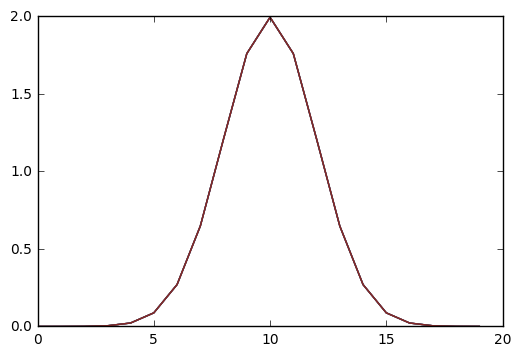

In [79]:
plt.plot(weight_mat, alpha = .5);

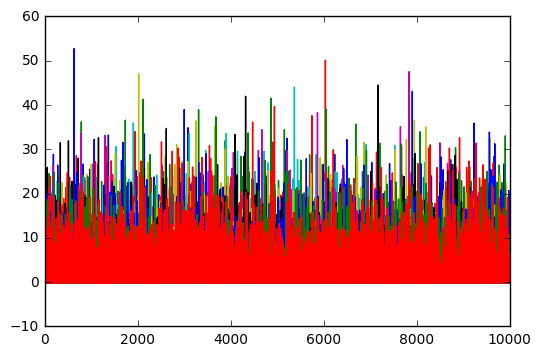

In [92]:
y -= np.min(y) + 1e-1

plt.plot(y);

In [98]:
import group_glm as gm
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stim[:, 0:num_features], y)

weight_init = np.linalg.pinv(X_train).dot(y_train) 

model = gm.exponential_GLM(weight_init, non_lin = tf.nn.sigmoid,  
                        train_params = True, lr = 5e-3, alpha = 0)


L, l = model.fit(X_train,y_train,X_test, y_test, max_iters = 1000, batch_size= 10)

w, o, s = model.get_params()
w = w.reshape(num_features, num_neurons)


0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:01


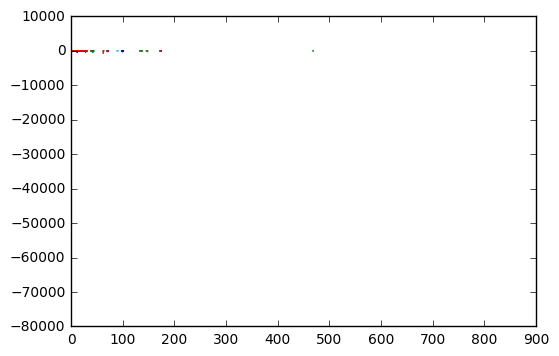

In [100]:
plt.plot(L)

0%  100%
[#   ] | ETA: 00:00:00

Fitting:  exponential  noise model with:  <function exp at 0x7f2902cca500>  non-linearity, and:  20 features


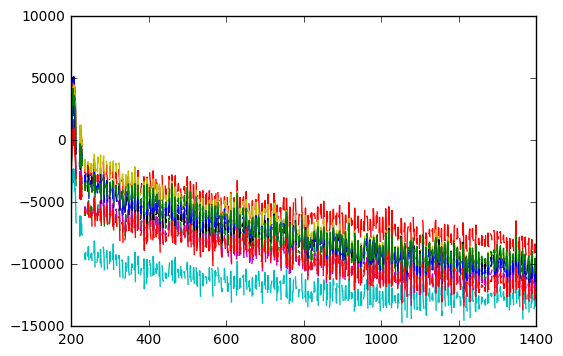

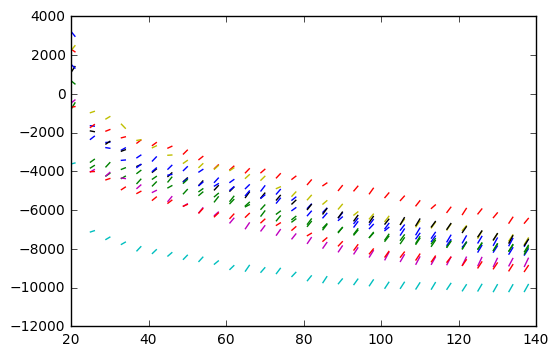

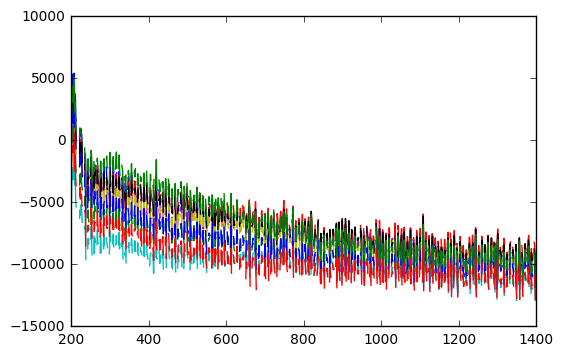

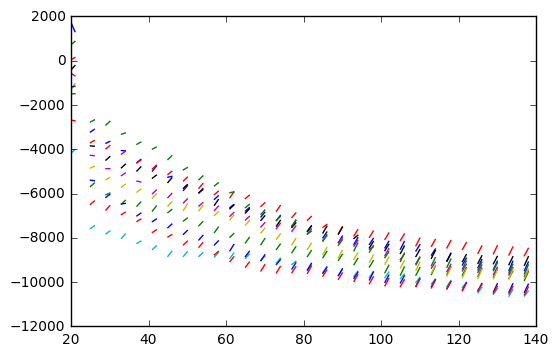

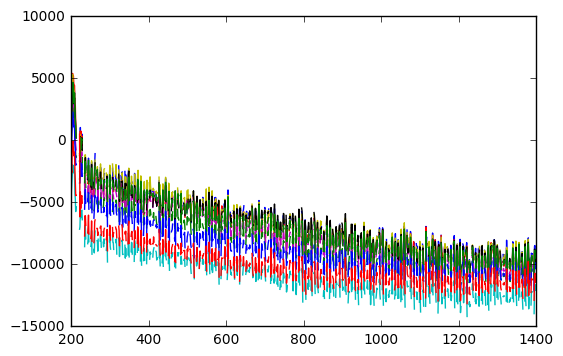

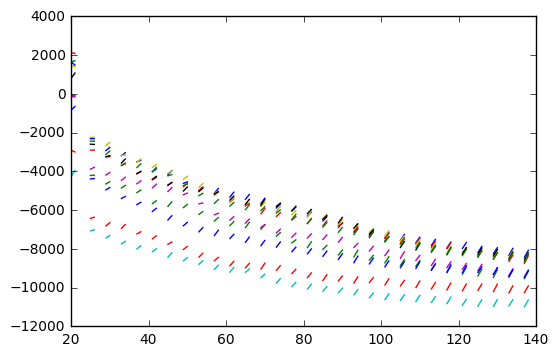

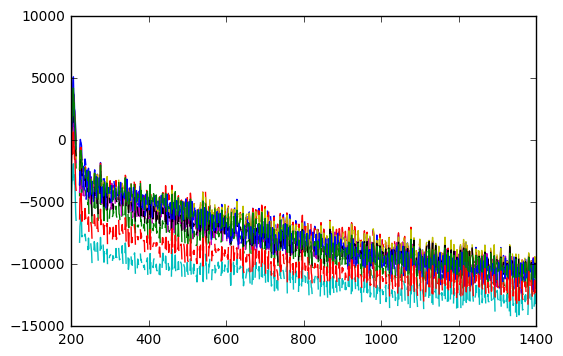

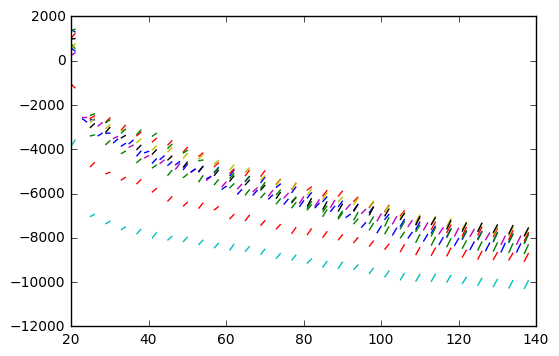

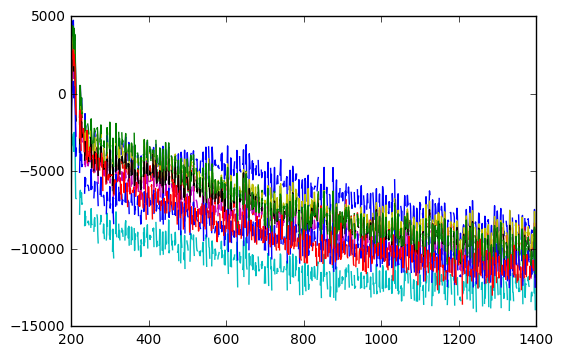

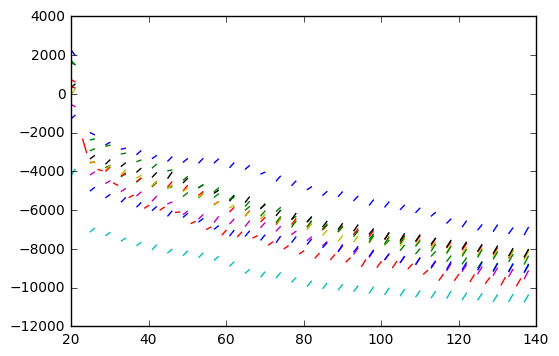

[##  ] | ETA: 00:01:29

Fitting:  exponential  noise model with:  <function sigmoid at 0x7f2902a38b90>  non-linearity, and:  20 features


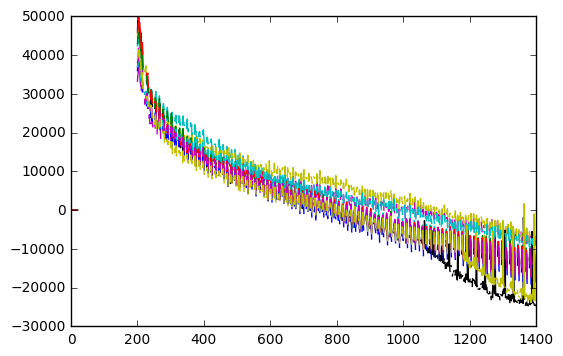

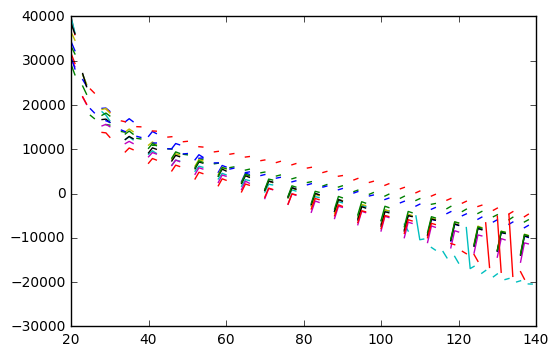

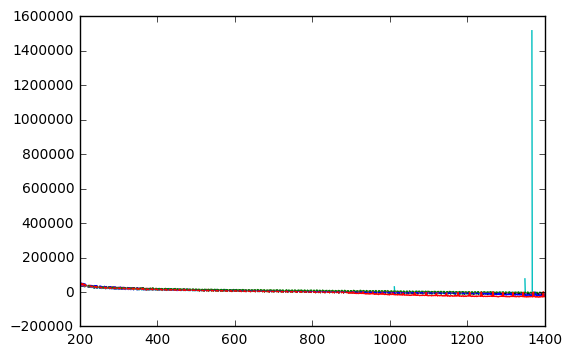

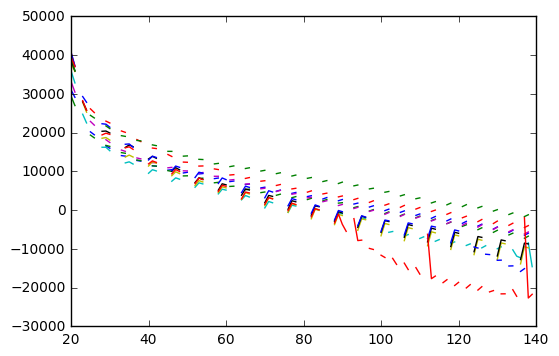

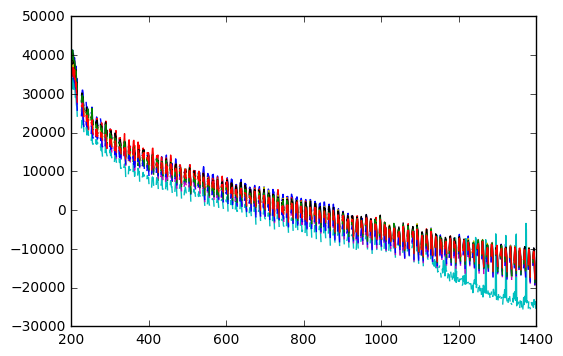

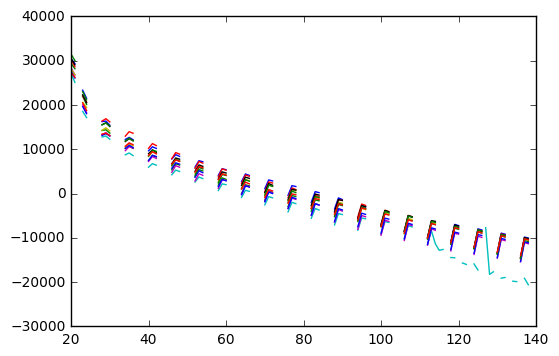

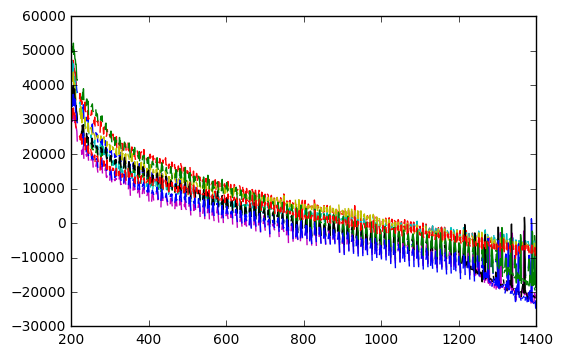

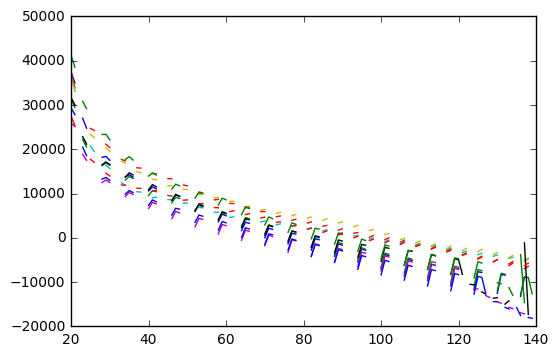

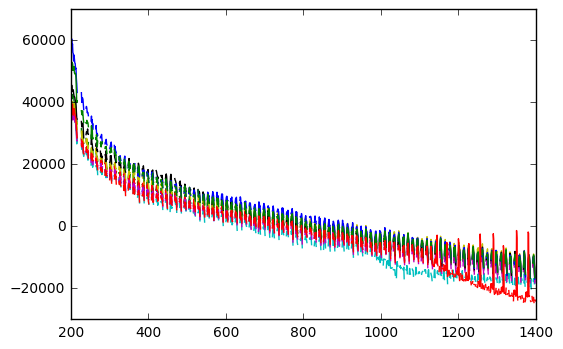

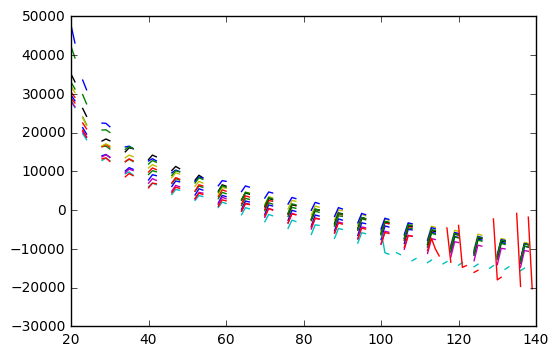

[### ] | ETA: 00:00:59

Fitting:  gaussian  noise model with:  <function exp at 0x7f2902cca500>  non-linearity, and:  20 features


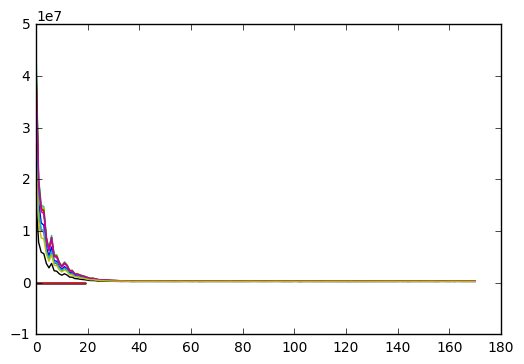

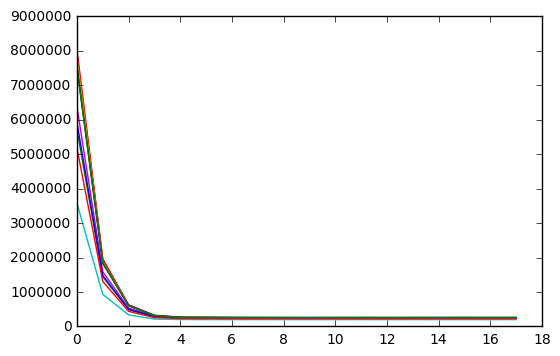

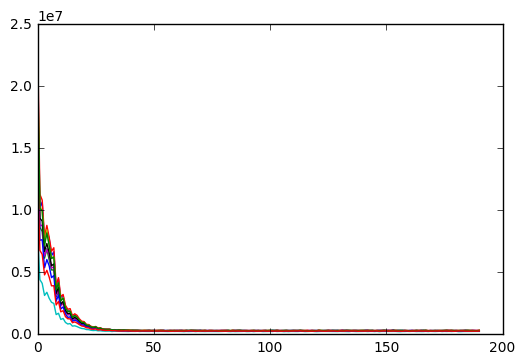

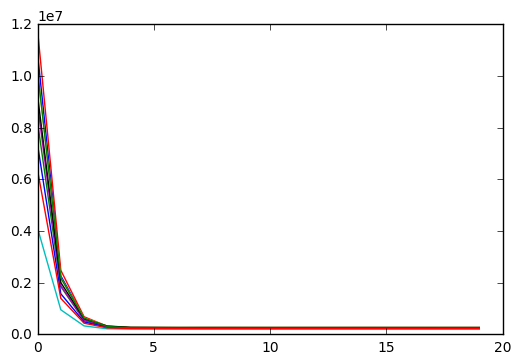

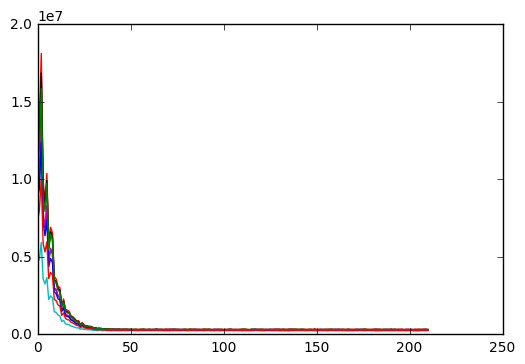

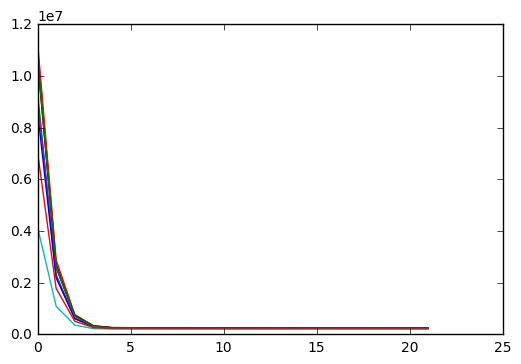

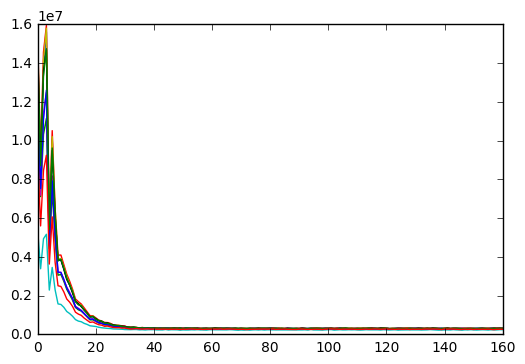

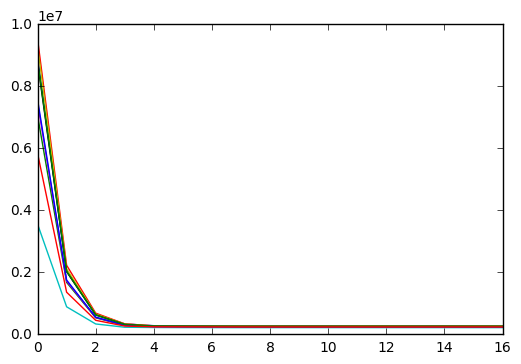

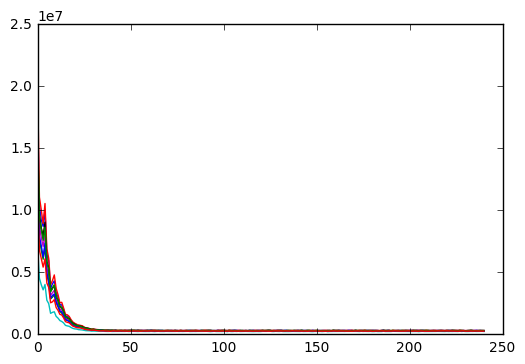

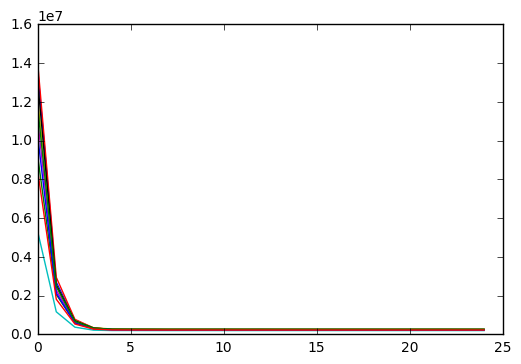

[####] | ETA: 00:00:00
Total time elapsed: 00:03:12


Fitting:  gaussian  noise model with:  <function sigmoid at 0x7f2902a38b90>  non-linearity, and:  20 features


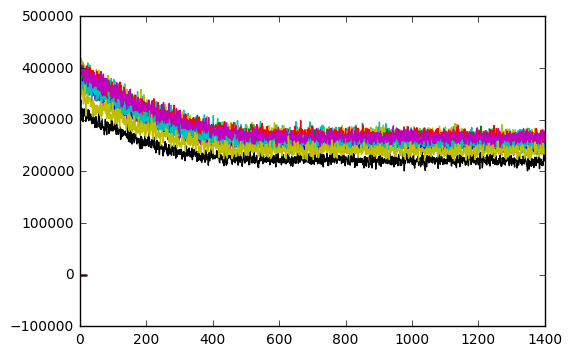

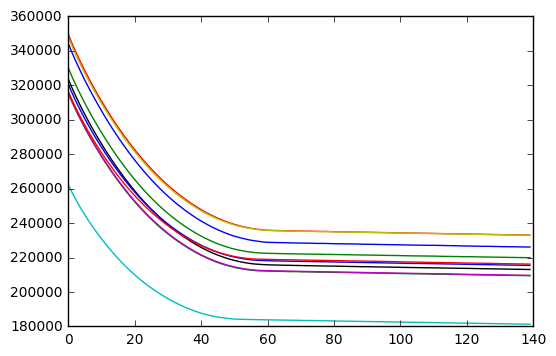

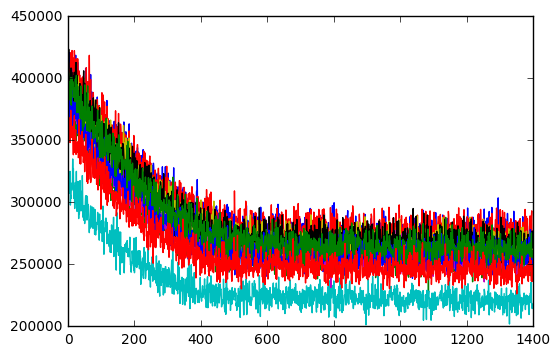

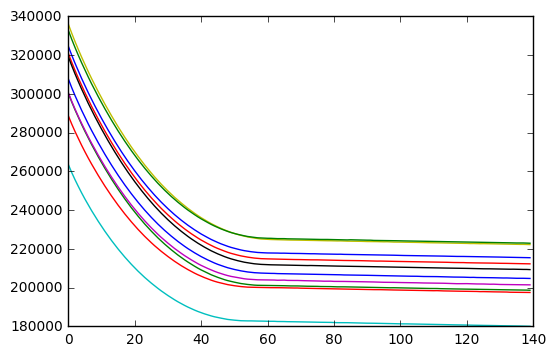

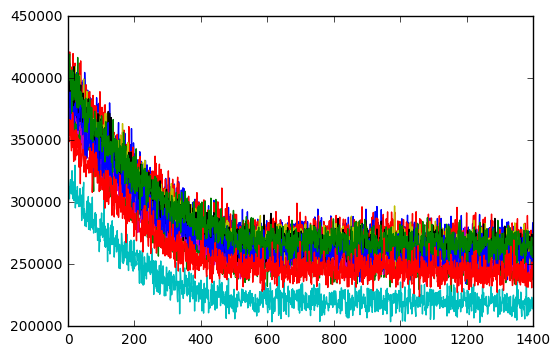

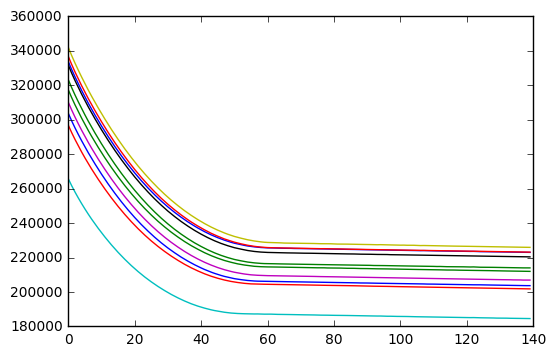

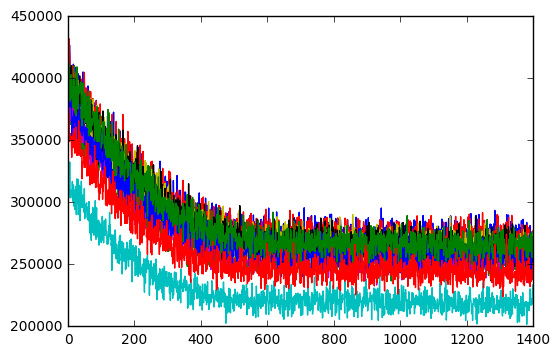

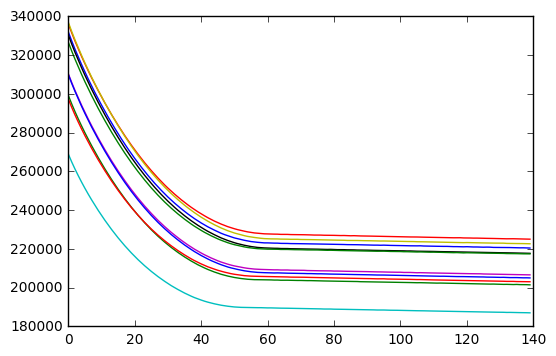

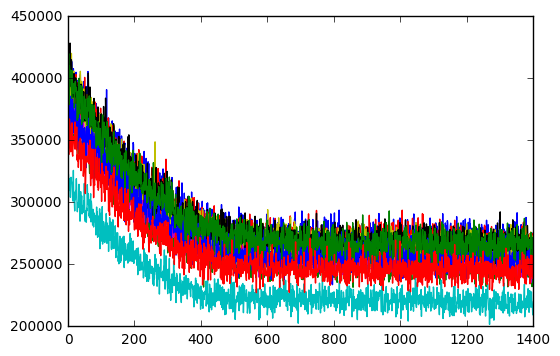

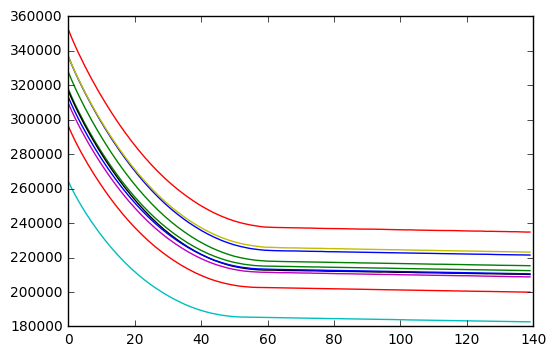

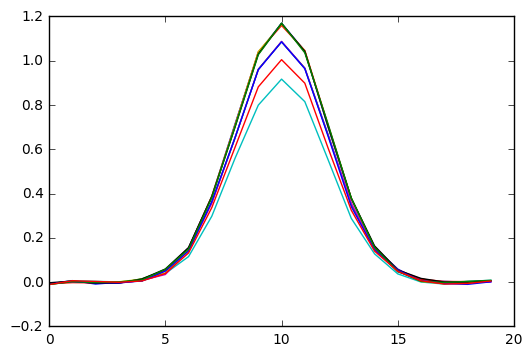

In [46]:
from fit_utils import fit_glm_CV

scores, features = fit_glm_CV(y, stim, learning_rate = [5e-3], 
                                      num_pcs = [num_features],debug = True, max_iters= 1400, batch_size = 30000,
                                      noise_model = ['exponential','gaussian'])

In [47]:
t_per_exp = []
t_per_gaus = []

t_per_l_exp = []
t_per_l_sig = []
t_per_l_sr = []

le_all = []
lg_all = []

distrib_n_pcs = []
distrib_lr = []

weights = []

scores[~np.isfinite(scores)] = -np.inf  


n_cells, n_nl, n_nm, npcs, n_lr = scores.shape

best_noise_model = []
best_non_linearity = []

likelihood_exponential = []
likelihood_gaussian = [] 

for i in range(n_cells):
    idx = np.argmax(scores[i])

    nl_ind, nm_ind, pc_ind, lr_ind = np.unravel_index(idx, (n_nl, n_nm, npcs, n_lr))

    if np.isfinite(scores[i, nl_ind, nm_ind, pc_ind, lr_ind]):
        best_noise_model.append(nm_ind)
        best_non_linearity.append(nl_ind)
        #distrib_n_pcs.append(pc_dict[pc_ind])
        distrib_lr.append(lr_ind)
        #weights.append(features[i, 0, 0, 0, 0, 0:num_features])
        weights.append(features[i, nl_ind, nm_ind, pc_ind, lr_ind, 0:num_features])

    else:
        print "Help non-finite likelihood"

weights = np.array(weights)
        
best_noise_model = np.array(best_noise_model)
best_non_linearity = np.array(best_non_linearity)

per_exp = sum(best_noise_model == 0) / float(len(best_noise_model))
per_gaus = sum(best_noise_model == 1) / float(len(best_noise_model))

per_l_exp = sum(best_non_linearity == 0) / float(len(best_non_linearity))
per_l_sig = sum(best_non_linearity == 1) / float(len(best_non_linearity))
per_l_sr = sum(best_non_linearity == 2) / float(len(best_non_linearity))

t_per_exp.append(per_exp)
t_per_gaus.append(per_gaus)

t_per_l_exp.append(per_l_exp)
t_per_l_sig.append(per_l_sig)
t_per_l_sr.append(per_l_sr)

le = np.array(scores[:, :, 0, :].flatten())
#le = le[np.isfinite(le)] 
lg = np.array(scores[:, :, 1, :].flatten())
#lg = lg[np.isfinite(lg)]
le_all.append(le)
lg_all.append(lg)    



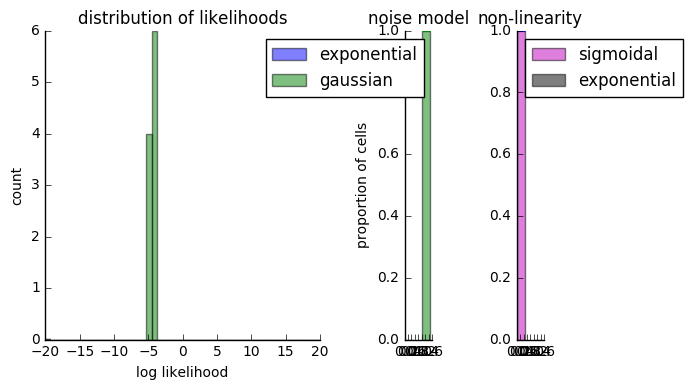

In [48]:
le_all_t = []
lg_all_t = []

for i in range(len(le_all)):
    for j in range(len(le_all[i])):
        le_all_t.append(le_all[i][j])

        
for i in range(len(lg_all)):
    for j in range(len(lg_all[i])):
        lg_all_t.append(lg_all[i][j])
 

le_all_hi = np.array(le_all_t)
le_all_hi = le_all_hi[np.isfinite(le_all_hi)]
lg_all_hi = np.array(lg_all_t).flatten()
lg_all_hi = lg_all_hi[np.isfinite(lg_all_hi)]

bins = np.linspace(-20, 20, num = 50)

plt.figure(figsize = [20, 3])
 
f, (a0, a1, a2) = plt.subplots(1,3, gridspec_kw = {'width_ratios':[10, 1, 1]})    
    
a0.hist(le_all_hi, alpha = .5, label = 'exponential', bins = bins);
a0.hist(lg_all_hi, alpha = .5, label = 'gaussian', bins = bins);
a0.set_ylabel('count')
a0.set_xlabel('log likelihood')
#a0.legend()
simpleaxis(a0, bottom = False)
a0.set_title('distribution of likelihoods')

a1.bar(0, np.mean(t_per_exp), yerr = np.std(t_per_exp),color = 'b', alpha = .5, width = .5,  label = "exponential")
a1.bar(1, np.mean(t_per_gaus), yerr = np.std(t_per_gaus), color = 'g', alpha = .5, width = .5, label = "gaussian")
a1.set_ylabel('proportion of cells')
a1.legend(loc = 'upper right')
a1.set_title('noise model')
simpleaxis(a2, bottom = False)

a2.bar(0, np.mean(t_per_l_exp), yerr = np.std(t_per_l_exp), width = .5, color = 'm', alpha = .5, label = "sigmoidal")
a2.bar(1, np.mean(t_per_l_sig), yerr = np.std(t_per_l_sig),width = .5, color = 'k', alpha = .5, label = "exponential")
a2.set_title('non-linearity')
a2.legend(loc ='upper left')
simpleaxis(a1, bottom = False)



f.tight_layout()

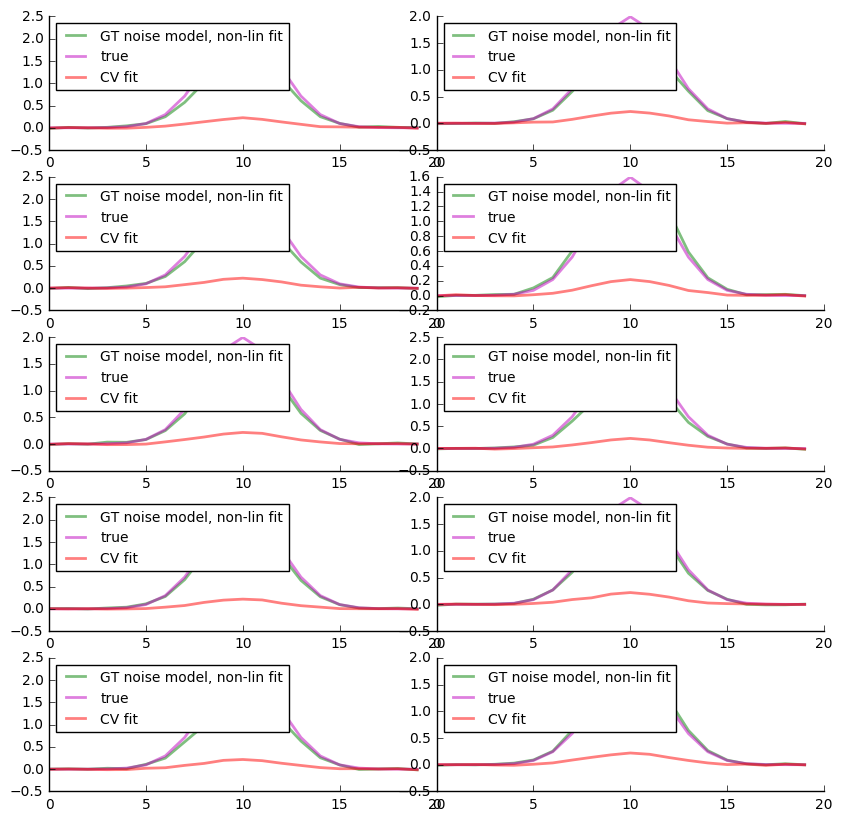

In [49]:
num_rows, num_cols = 5, 2


plt.figure(figsize = [10, 10])
gs, ax = gridplot(num_rows, num_cols)

for i, axes in enumerate(ax):
    axes.plot(w[:, i], c = 'g', linewidth = 2, alpha = .5, label = 'GT noise model, non-lin fit')
    #axes.plot(weight_inits[:, i], c = 'g', linewidth = 1, alpha = .5, label = 'inits')
    axes.plot(weight_mat[:, i], c = 'm', linewidth = 2, alpha = .5, label = 'true')
    axes.plot(weights[i, :], c = 'r', linewidth = 2, alpha = .5, label = 'CV fit')
    axes.legend(fontsize = 10, loc = 'upper left')
    simpleaxis(axes)

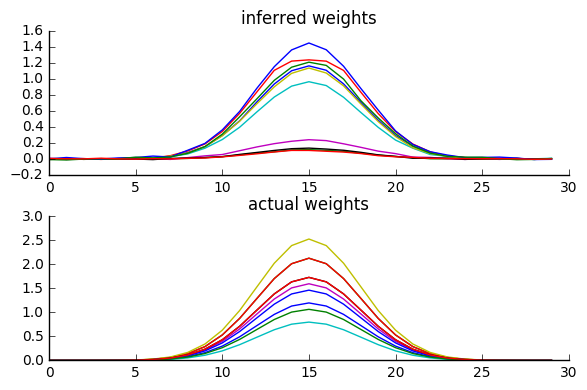

In [356]:


ax = plt.subplot(211)
plt.tight_layout()
plt.plot(weights.T);
plt.title('inferred weights')
simpleaxis(ax)

ax = plt.subplot(212)
plt.tight_layout()
plt.plot(weight_mat);
plt.title('actual weights')
simpleaxis(ax)

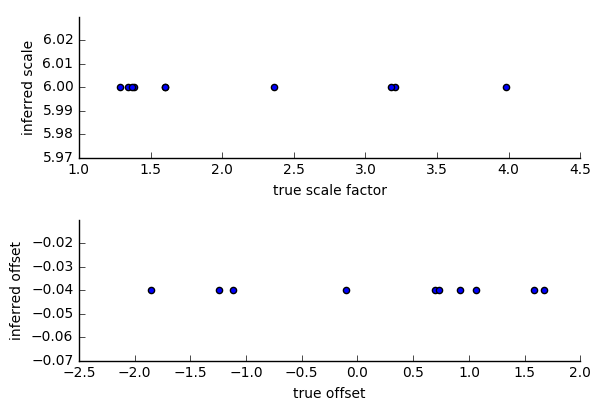

In [328]:
ax = plt.subplot(211)
plt.tight_layout()
plt.scatter(scale_true, s)
plt.xlabel('true scale factor')
plt.ylabel('inferred scale')
simpleaxis(ax)

ax = plt.subplot(212)
plt.tight_layout()
plt.scatter(offset_true, o)
plt.xlabel('true offset')
plt.ylabel('inferred offset')
simpleaxis(ax)